Clayton Cohn <br>
11 Oct 2022 <br>
OELE Lab <br>
Vanderbilt University <br>

# <center> Tagging Concepts for Automated Assessment Evaluation w/ BERT

## Attribution

Certain parts of this notebook were adapted from Drew Perkins' tutorial via Towards Data Science: 

https://towardsdatascience.com/tagging-genes-and-proteins-with-biobert-c7b04fc6eb4f

## Introduction

This notebook is created by Clayton Cohn to provide a real-world code example using [BERT](https://arxiv.org/abs/1810.04805) for the author's DS5899 — Special Topics: Transformers paper presentation.

This notebook was used in the author's research for tagging scientific concepts in student essays for the purpose of evaluating programmatic means of automated formative assessment evaluation.

The data was collected via a study of 5th and 6th grade student participants as part of the [SPICE](https://spiceprojects.org/) (Science Projects Integrating Computing and Engineering) initiative. The data was collected and annotated by the author's colleague and lab-mate, Dr. Nicole Hutchins, for analysis.

Students were presented a diagram that used arrows to display where water goes during and after precipitation. They were then asked to identify what the size of each arrow meant. Each instance in the dataset is an individual student response to this question. 

The correct answer is that the size of the arrow is indicative of the quantity of water. The idea behind this notebook is to tag specific sentence fragments that correctly identify the meaning behind the size of the arrows. By doing this, we accomplish two things:

1.   Determine whether or not the student correctly answered the question, i.e. sentence-level classification
2.   Identify *where*, if anywhere, the student correctly answered the question, i.e. WordPiece-level tagging.

By accomplishing these tasks, the model will be able to  provide programmatic formative assessment evaluation for teachers' feedback to students.



## Preprocessing

### Data Gathering

This notebook is created via Google Colab. As such, the Google Drive must be mounted to access it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define file name and path name constants to use to access the data from Google Drive

In [2]:
DATA_PATH = "drive/My Drive/VU_DPU/data/"
FILE_NAME = "meigs-fa1-q1-iob2_AUGMENTED.csv"

We also need to define our random seeds, as we will alternate between these during the testing phase.

The ```it``` value is so that we can iterate through the seeds easily.

In [3]:
it = 6
seeds = [0, 2, 7, 31, 2025, 112358, 19861115]

Import data into Pandas DataFrame for analysis.

In [4]:
import pandas as pd

# Enable longer printing
pd.set_option('display.max_rows', 5000)

df = pd.read_csv(DATA_PATH + FILE_NAME)
df.head(5)

,sent,word,tag,labels
0,Sentence 2,Once,O,['0']
1,NaN,it,O,NaN
2,NaN,reaches,O,NaN
3,NaN,the,O,NaN
4,NaN,ground,O,NaN


Get rid of NaN values to avoid errors when working with the DataFrame.

In [5]:
import numpy as np

df_num = df.copy(deep=True)
df_num.iloc[0]["sent"] = 0
df_num.columns = ["s_num","word","tag","labels"]
df_num = df_num.fillna(-1)

snum = -1
for idx, row in df_num.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_num.head(5)

,s_num,word,tag,labels
0,0,Once,O,['0']
1,0,it,O,-1
2,0,reaches,O,-1
3,0,the,O,-1
4,0,ground,O,-1


### EDA (Exploratory Data Analysis)

Ensure all null values removed.

In [6]:
print("Any nulls? ", df_num.isnull().values.any())

Any nulls?  False


See how the sentences break down by class.

In [7]:
labels = df_num["labels"].to_numpy()
others = []
for n in labels:
  others.append(n)

res = {}

for n in others:
  if n == -1: continue
  if n[2] not in res: res[n[2]] = 1
  else: res[n[2]] += 1
  
print(res)

# df_sent = df_num[df_num["labels"] != -1]
# df_sent['labels'] = df_sent['labels'].str[2]

# df_sent_ones = df_sent[df_sent["labels"] == "1"]
# df_sent_zeros = df_sent[df_sent["labels"] == "0"]

# print(f"0: {len(df_sent_zeros)}, 1: {len(df_sent_ones)}\n")

{'0': 103, '1': 86}


Ensure that the sentence number is correctly identified by Python as a numerical representation.

In [8]:
df_num["s_num"] = df_num["s_num"].astype(str).astype(int)

In traditional NLP tagging approaches, the BIO scheme is used; however, in this case, this is unnecessary, so the Bs and Is will be removed.

In [9]:
df_num["tag"] = df_num.apply(lambda x: x["tag"][2:] if x["tag"][:2] in ["B-", "I-"] else x["tag"], axis=1)

In [10]:
df_num["tag"] = df_num.apply(lambda x: x["tag"] if x["tag"] in ["AMOUNT-1-1"] else "O", axis=1)

Let's examine the DataFrame and make sure that the correct labels exist on the word level.

In [11]:
print("Shape:", df_num.shape)
print(df_num.info())

Shape: (2538, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2538 entries, 0 to 2537
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s_num   2538 non-null   int64 
 1   word    2538 non-null   object
 2   tag     2538 non-null   object
 3   labels  2538 non-null   object
dtypes: int64(1), object(3)
memory usage: 79.4+ KB
None


In [12]:
print("Unique labels:")
sorted(df_num.tag.unique())

Unique labels:


['AMOUNT-1-1', 'O']

Let's see the tag distribution across the dataset.

In [13]:
print(df_num.tag.value_counts())

O             2116
AMOUNT-1-1     422
Name: tag, dtype: int64


Now we will see which sentences are the longest. This will be used when determining the maximum input length to BERT.

In [14]:
print(df_num.s_num.value_counts()[:5])

123    62
21     40
4      38
91     37
83     35
Name: s_num, dtype: int64


### Sentence Creation (from words in DataFrame)

```SentenceGetter``` class c/o Nasir Safdari via TDS🇰
https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede

It is used to extract full sentences from the DataFrame that are currently represented as individual words.

In [15]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, l) for w, l in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
      self.grouped = self.data.groupby("s_num").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [16]:
getter = SentenceGetter(df_num)

This is an example of one of the instances returned by the SentenceGetter (both words and word tags).

In [17]:
sents = [[word[0] for word in sentence] for sentence in getter.sentences]
sents[0]

['Once',
 'it',
 'reaches',
 'the',
 'ground',
 'some',
 'of',
 'it',
 'absorbs',
 'and',
 'the',
 'rest',
 'gets',
 'poluted',
 'and',
 'flows',
 'right',
 'into',
 'the',
 'stream']

In [18]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We have to store the set of tags and map them to indices to feed into BERT. Additionally, the PAD tag needs to be added because it will be used during training.

In [19]:
tag_values = list(set(df_num["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

### Install and Import Libraries

We need to install Transformers and Torch to run BERT.

In [20]:
!pip install transformers;
!pip install torch;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.1 MB/s 
     |████████████████████████████████| 163 kB 85.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.12.1+cu113'

Colab offers free GPUs for training, so we will run our model on the GPU (if we can).

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

### Prepare Tokenization

We will use the standard tokenizer provided by the Transformers module.

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

This function will zip tokens and labels into individual sentences for training. It is also adopted from the aforementioned TDS source.

In [24]:
def tokenize_with_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

### Split Into Training and Testing Partitions

Define a constant that identifies the maximum ```s_num``` feature from the DataFrame. 1 + MAX_SENT = number of sentences in DataFrame.

In [25]:
MAX_SENT = df_num.iloc[-1]["s_num"]
MAX_SENT

188

We will split into training and test sets. Before training, we will partition a portion of the training set for validation purposes. 

As an alternative to cross-validation, I have chosen 7 random seeds to partition the data several different ways. This is what we did for our initial IJAIED submission.  

In [26]:
import random

TEST_PERCENT = 0.25

random.seed = seeds[it]

test = random.sample(range(0,MAX_SENT+1), int(MAX_SENT * TEST_PERCENT))
test[:5]

[126, 17, 118, 110, 53]

We will break apart the DataFrame into training and test partitions based on the random seed.

In [27]:
df = df_num[~df_num['s_num'].isin(test)]
df.head(5)

,s_num,word,tag,labels
0,0,Once,O,['0']
1,0,it,O,-1
2,0,reaches,O,-1
3,0,the,O,-1
4,0,ground,O,-1


In [28]:
df_test = df_num[df_num['s_num'].isin(test)]
df_test.head(5)

,s_num,word,tag,labels
28,2,It,O,['0']
29,2,very,O,-1
30,2,slowly,O,-1
31,2,absorbs,O,-1
32,2,.,O,-1


## Training

### Prep Instances for Training

Now we can use the tokenize function from earlier to tokenize each sentence in our training set for BERT training. We can then separate the texts from the labels.

In [29]:
tokenized_texts_and_labels = [tokenize_with_labels(sent, labs) for sent, labs in zip(sents, labels)]

In [30]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

Define max sequence length and batch size hyperparameters.

For this dataset, there are only about 70 training instances with a 25% test set partition. Still, BERT recommends batch sizes of 16 or 32, and 16 seems to work. It will be worth tuning this hyperparameter in particular later on.

In [31]:
MAX_LEN = max(map(len, tokenized_texts))
BATCH_SIZE = 16

print("MAX_LEN:",MAX_LEN)

MAX_LEN: 63


Map individual BERT tokens to their corresponding IDs in BERT's vocabulary.

In [32]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

Get the tags array, complete with padding. ```pad_sequences``` is provided by Keras.

In [33]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

Prep the attention masks. They will start at 0.

In [34]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

Split the inputs, tags, and masks into training and validation partitions.

In [35]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=seeds[it], test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=seeds[it], test_size=0.1)

Tensorize inputs.

In [36]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

Create training and validation dataloaders.

In [37]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

### Prep Model for Training

We can use the off-the-shelf Transformers BERT implementation provided specifically for tokenization tasks such as POS, NER, etc.

We will also grab the Adam optimizer, which is standard but is also an additional hyperparameter capable of being tuned. 

In [38]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.23.1'

Instantiate the model and move it to the GPU.

In [39]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
);

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [40]:
model.cuda();

Learing rate and whether or not we are doing fine-tuning are defined as constants.

In [41]:
FULL_FINETUNING = True
LEARNING_RATE = 3e-5

Optimizer is instantiated for training.

In [42]:
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Learning rate scheduler setup along with EPOCHS hyperparameter constant. This code was adopted from the TDS source listed above.

In [43]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 8

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Perform Training

We need to install the seqeval library for evaluation purposes.

In [44]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=393edc19f0feb07a08ed49b27bf6cf2c738b47b541ab30b7aee5e158becc654e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


This is the actual training. We will use TQDM to see our progress as we go. This code also adopted from TDS source.

Additionally, we will evaluate our training on the validation data.

In [45]:
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print()

Epoch:  12%|█▎        | 1/8 [00:04<00:34,  4.93s/it]

Average train loss: 0.6056312620639801
Validation loss: 0.39840443432331085
Validation Accuracy: 0.577922077922078



Epoch:  25%|██▌       | 2/8 [00:07<00:20,  3.36s/it]

Average train loss: 0.2780876647342335
Validation loss: 0.12529423832893372
Validation Accuracy: 0.8311688311688312



Epoch:  38%|███▊      | 3/8 [00:09<00:14,  2.86s/it]

Average train loss: 0.11374825171448967
Validation loss: 0.04844203591346741
Validation Accuracy: 0.9253246753246753



Epoch:  50%|█████     | 4/8 [00:11<00:10,  2.62s/it]

Average train loss: 0.05734641291201115
Validation loss: 0.02385651972144842
Validation Accuracy: 0.961038961038961



Epoch:  62%|██████▎   | 5/8 [00:13<00:07,  2.50s/it]

Average train loss: 0.034856986085122284
Validation loss: 0.0181444538757205
Validation Accuracy: 0.9675324675324676



Epoch:  75%|███████▌  | 6/8 [00:16<00:04,  2.42s/it]

Average train loss: 0.023945114321329376
Validation loss: 0.01935699419118464
Validation Accuracy: 0.9642857142857143



Epoch:  88%|████████▊ | 7/8 [00:18<00:02,  2.38s/it]

Average train loss: 0.01976166902617975
Validation loss: 0.018637280678376555
Validation Accuracy: 0.9675324675324676



Epoch: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it]

Average train loss: 0.017737952484325928
Validation loss: 0.0190418268321082
Validation Accuracy: 0.9642857142857143



### Training Evaluation

Graph training and validation loss. Code adopted from TDS source.

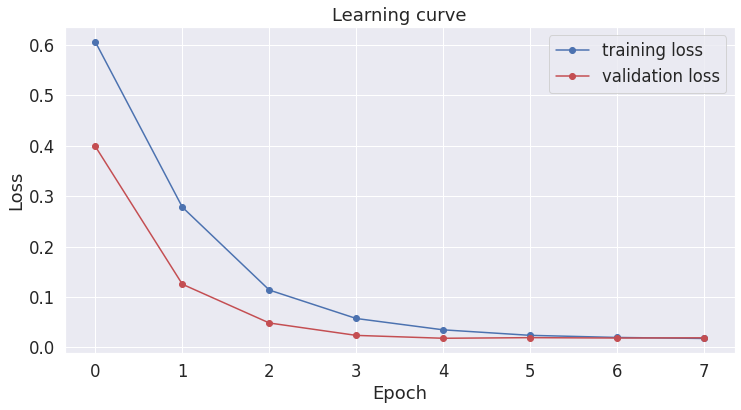

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Examine performance metrics from training (via validation data).

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

  AMOUNT-1-1       0.91      0.79      0.85        39
           O       0.97      0.99      0.98       269

    accuracy                           0.96       308
   macro avg       0.94      0.89      0.91       308
weighted avg       0.96      0.96      0.96       308



Examine confusion matrix from training (via validation data).

In [48]:
# import seaborn as sns

# cf_matrix = confusion_matrix(valid_tags, pred_tags)
# group_names = ["True Neg","False Pos","False Neg","True Pos"]
# group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
# t_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
# t_labels = np.asarray(t_labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=t_labels, fmt='', cmap='Blues')

## Testing

### Prep Testing

First we will create the test set DataFrame. This is based on the random indexes generated earlier that were not used for training. 

We also need to get rid of the NaNs and set the sentence numbers for reference.

In [49]:
df_test = df_test.copy(deep=True)
df_test.iloc[0]["sent"] = 0
df_test.columns = ["s_num","word","tag", "labels"]
df_test = df_test.fillna(-1)

snum = -1
for idx, row in df_test.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_test.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


,s_num,word,tag,labels
28,2,It,O,['0']
29,2,very,O,-1
30,2,slowly,O,-1
31,2,absorbs,O,-1
32,2,.,O,-1


Check for NaN's remaining.

In [50]:
print("Any nulls? ", df_test.isnull().values.any())

Any nulls?  False


Now we need to convert the labels to integers.

In [51]:
df_test["labels"] = df_num.apply(lambda x: x["labels"] if x["labels"] == -1 else x["labels"][2], axis=1)
df_test.head(5)

,s_num,word,tag,labels
28,2,It,O,0
29,2,very,O,-1
30,2,slowly,O,-1
31,2,absorbs,O,-1
32,2,.,O,-1


This cell ensures that the s_num attribute is an integer, and it remoes the B and I prefixes from the tags. This was already done before the data was partitioned into training and testing, however, so they will be commented out.

In [52]:
# df_test["s_num"] = df_test["s_num"].astype(str).astype(int)
# df_test["tag"] = df_test.apply(lambda x: x["tag"][2:] if x["tag"][:2] in ["B-", "I-"] else x["tag"], axis=1)

Make sure that we have only one tag and that the rest or Os.

In [53]:
df_test["tag"] = df_test.apply(lambda x: x["tag"] if x["tag"] in ["AMOUNT-1-1"] else "O", axis=1)

Examine the labels to make sure this was successful.

In [54]:
print("Unique labels:")
sorted(df_test.tag.unique())

Unique labels:


['AMOUNT-1-1', 'O']

### Test Set EDA

Ensure that our types are correct and examine the test set.

In [55]:
print("Shape:", df_test.shape)
print(df_test.info())

Shape: (610, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 28 to 2468
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s_num   610 non-null    int64 
 1   word    610 non-null    object
 2   tag     610 non-null    object
 3   labels  610 non-null    object
dtypes: int64(1), object(3)
memory usage: 23.8+ KB
None


Examine the test tag distribution.

In [56]:
print(df_test.tag.value_counts()[:10])

O             519
AMOUNT-1-1     91
Name: tag, dtype: int64


Examine the test sentence lengths.

In [57]:
print(df_test.s_num.value_counts()[:10])

4      38
83     35
136    32
41     25
20     22
134    19
45     19
147    19
126    18
105    16
Name: s_num, dtype: int64


### Perform Testing

This is used for debugging to see the breakdowns of tags for each instance (sentence) in the test set.

In [58]:
y_pred = []
y_true = []
y_tokens = []
test_pred = []

for i in test:
  first_sent_word = list(df_test[df_test["s_num"] == i]["word"])
  first_sent_label = ["O"] + list(df_test[df_test["s_num"] == i]["tag"]) + ["O"]

  test_sentence = ""
  for val in first_sent_word:
    test_sentence += val + ' '
  # print(test_sentence) 

  test_tokenized_sentence = tokenizer.encode(test_sentence)
  test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(test_input_ids)
  test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, idx in zip(test_tokens, test_label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[idx])
          new_tokens.append(token)
  # print(new_labels)
  y_pred += new_labels
  y_true += first_sent_label
  y_tokens += new_tokens
  test_pred.append(set(new_labels))

### Test Set Tagging Evaluation

We first silence any instance of an ```UndefinedMetricWaring```, as they can become cumbersome.

In [74]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings

warnings.warn = warn

Examine the classification report from tagging.

In [85]:
report = classification_report(y_true, y_pred, output_dict=True) # True to save in CSV
report = {k: v for k, v in report.items() if k != "PAD"}

for k, v in report.items():
  if k != "accuracy":
    v_round = {kr: round(vr,2) for kr, vr in v.items()}
    report[k] = v_round

acc = 0

for k, v in report.items():
  if k == "O":
    print(k,"\t\t\t", v)
  elif k == "accuracy":
    acc = report[k]
  else:
    print(k,"\t\t", v)

print("accuracy\t\t",acc)

AMOUNT-1-1 		 {'precision': 0.97, 'recall': 0.4, 'f1-score': 0.56, 'support': 91}
O 			 {'precision': 0.93, 'recall': 0.87, 'f1-score': 0.9, 'support': 613}
macro avg 		 {'precision': 0.63, 'recall': 0.42, 'f1-score': 0.49, 'support': 704}
weighted avg 		 {'precision': 0.94, 'recall': 0.81, 'f1-score': 0.85, 'support': 704}
accuracy		 0.8068181818181818


Examine an individual instance to see what was tagged and how.

In [86]:
n = test[0]
first_sent_word = list(df_test[df_test["s_num"] == n]["word"])
first_sent_label = ["O"] + list(df_test[df_test["s_num"] == n]["tag"])
test_sentence = ""
for val in first_sent_word:
  test_sentence += val + ' '
print("Sentence:",test_sentence,"\n") 

test_tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(test_input_ids)
test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token, idx in zip(test_tokens, test_label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[idx])
        new_tokens.append(token)
print("Pred\t\tWord\t\tTrue\n")
for token, label, old in zip(new_tokens[1:], new_labels[1:], first_sent_label[1:]):
    print("{}\t{}\t{}".format(label if label != "O" else label+"\t", \
                              token+"\t" if len(token) < 8 else token, \
                              old))

Sentence: It could mean how much water is going to places , or show how much it happens different  

Pred		Word		True

O		It		O
O		could		O
O		mean		O
O		how		AMOUNT-1-1
AMOUNT-1-1	much		AMOUNT-1-1
O		water		AMOUNT-1-1
O		is		O
O		going		O
O		to		O
O		places		O
O		,		O
O		or		O
O		show		O
O		how		O
O		much		O
O		it		O
O		happens		O
O		different	O


This next cell an be used for debugging to examine specific instances and their tags.

In [61]:
# df_test[df_test['s_num'] == test[-2]].head(5)

### Sentence Classification

The sentence classification is based on whether or not a sigle occurrence of a tag was detected anywhere in the sentence. If there is a predicted ```AMOUNT-1-1``` tag, then the sentence will be predicted as belonging to the class that correctly answered the question.

Separate labels/sentences by individual sentences.


In [62]:
test_sents = []
test_labels = []

for n in test:
        
  label = list(df_test[df_test["s_num"] == n]["labels"])[0]
  test_labels.append(label)
  words = list(df_test[df_test["s_num"] == n]["word"])
  sentence = ""
  for val in words:
    sentence += val + ' '
  test_sents.append(sentence)

print(len(test_sents), len(test_labels))

47 47


Get the preicted class based on whether or not a label was present.

In [63]:
test_pred_n = [1 if "AMOUNT-1-1" in test_pred[i] else 0 for i in range(len(test_pred))]
test_pred_n[:5]

[1, 0, 1, 1, 0]

Get the true test labels.

In [64]:
test_labels = [int(n) for n in test_labels]
test_labels[:5]

[1, 0, 1, 1, 0]

### Sentence Classification Evaluation

Get the classification report for sentence prediction.

In [65]:
report = classification_report(test_labels, test_pred_n, output_dict=False) # True to save in CSV
print(report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.95      0.90      0.93        21

    accuracy                           0.94        47
   macro avg       0.94      0.93      0.94        47
weighted avg       0.94      0.94      0.94        47



Examine sentence classification confusion matrix.

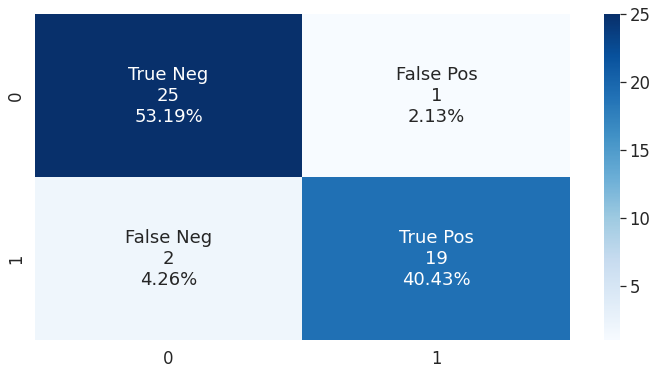

In [66]:
cf_matrix = confusion_matrix(test_labels, test_pred_n)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
t_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
t_labels = np.asarray(t_labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=t_labels, fmt='', cmap='Blues')